In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Define elements to use:

els = ['Fe', 'He', 'Mg', 'Ne', 'O', 'Si'] # TNG elements but removing C and N for proto-solar corrections

# Load training data:
full_input = '/mnt/store1/oliverphilcox/ChempyMultiData/All_Timestep_Training_Predictions.npz'
dat=np.load(full_input,mmap_mode='r')
all_els = dat['elements']
params=dat['params']
times=dat['timestep']

big_abun=dat.f.abundances
el_indices=np.zeros(len(els),dtype=int)
for e,el in enumerate(els):
    el_indices[e]=np.where(el==all_els)[0]
    
# Filter out unwanted elements
abun = big_abun[:,el_indices]


In [265]:
# Define elements to use:

import os
os.chdir('/home/oliverphilcox/ChempyMulti/')
from Chempy.parameter import ModelParameters
a=ModelParameters()

#els = a.initial_neural_names
els = ['Fe', 'He', 'Mg', 'Ne', 'O', 'Si'] # TNG elements but removing C and N for proto-solar corrections

# Load training data:
full_input = '/mnt/store1/oliverphilcox/ChempyMultiData/Variable_Time_Test_Predictions_500000.npz'
full_input2 = '/mnt/store1/oliverphilcox/ChempyMultiData/Variable_Time_Test_Predictions_500000_2.npz'
dat=np.load(full_input,mmap_mode='r')
dat2=np.load(full_input2,mmap_mode='r')
all_els = dat['elements']
params=np.concatenate([dat['params'],dat2['params']])

big_abun=np.concatenate([dat.f.abundances,dat2.f.abundances])
el_indices=np.zeros(len(els),dtype=int)
for e,el in enumerate(els):
    el_indices[e]=np.where(el==all_els)[0]
    
# Filter out unwanted elements
abun = big_abun[:,el_indices]


First remove any data which couldn't be sampled. (These regions in parameter space will be excluded from the priors).

In [266]:
bitmap=np.ones(len(params),dtype=int)
for i,ab in enumerate(abun):
    if ab[0]==0:
        bitmap[i]=0

In [267]:
cut_params=params[np.where(bitmap==1)]
cut_abuns=abun[np.where(bitmap==1)]

Also remove any NaN points (just one point in the extremal edges of parameter space so unimportant). We'll also remove any timesteps for $t<1$ here.

In [268]:
good_index=np.where(np.isfinite(cut_abuns).all(axis=1))[0]#&(params[:,-1]>0.99)))[0]
cut_params2=cut_params[good_index]
cut_abuns2=cut_abuns[good_index]
good_index2=np.where(cut_params2[:,-1]>0.99)[0]
cut_params3=cut_params2[good_index2]
cut_abuns3=cut_abuns2[good_index2]

Normalize these input parameters:

In [269]:
par_mean=np.mean(cut_params3,axis=0)
par_std=np.std(cut_params3,axis=0)
ab_mean=np.mean(cut_abuns3,axis=0)
ab_std=np.std(cut_abuns3,axis=0)

# Change t mean/std to give t in [-1,1]
par_mean[-1]=0.5*(max(cut_params3[:,-1])+min(cut_params3[:,-1]))
par_std[-1]=0.5*(max(cut_params3[:,-1])-min(cut_params3[:,-1]))

trainX=(cut_params3-par_mean)/par_std
trainY=(cut_abuns3-ab_mean)/ab_std

In [270]:
print('Using %d training data points for a %d->%d shape network'%(trainX.shape[0],trainX.shape[1],trainY.shape[1]))

Using 998289 training data points for a 6->6 shape network


Only take a small subset for testing:

In [271]:
#indices=np.random.randint(0,len(trainX),100000)
#trainX=trainX[indices]
#trainY=trainY[indices]

Build neural net:

In [272]:
# Parameters
#neurons = 20
learning_rate = 0.05
epochs=200

Load validation set:

In [273]:
# Load training data:
datT=np.load('/mnt/store1/oliverphilcox/Variable_Time_Test_Predictions.npz')
abunT=datT.f.abundances[:,el_indices]
elsT=datT.f.elements
paramsT=datT.f.params

bitmapT=np.ones(len(paramsT),dtype=int)
for i,ab in enumerate(abunT):
    if ab[0]==0:
        bitmapT[i]=0
                
# Remove dodgy data
cut_paramsT=paramsT[np.where(bitmapT==1)]
cut_abunsT=abunT[np.where(bitmapT==1)]
good_indexT=np.where(np.isfinite(cut_abunsT).all(axis=1))[0]
cut_params2T=cut_paramsT[good_indexT]
cut_abuns2T=cut_abunsT[good_indexT]

# Standardize using same standardizations as before
testX=(cut_params2T-par_mean)/par_std
testY=(cut_abuns2T-ab_mean)/ab_std
print("Using %d test data points"%testX.shape[0])

Using 49919 test data points


In [274]:
n_train = len(trainX)

# Dimensions
dim_in = trainX.shape[1]
dim_out= trainY.shape[1]

import torch
from torch.autograd import Variable

# Convert to torch variables
tr_input = Variable(torch.from_numpy(trainX)).type(torch.FloatTensor)
tr_output = Variable(torch.from_numpy(trainY), requires_grad=False).type(torch.FloatTensor)

te_input = Variable(torch.from_numpy(testX),requires_grad=False).type(torch.FloatTensor)
te_output = Variable(torch.from_numpy(testY),requires_grad=False).type(torch.FloatTensor)

Define the neural network model:

In [329]:
hidden_layer_1, hidden_layer_2 = 10, 40

def one_layer_model(neurons=10):
    model = torch.nn.Sequential(
        torch.nn.Linear(dim_in,neurons),
        torch.nn.ReLU(),
        torch.nn.Linear(neurons,dim_out)
    )
    return model


#two_layer = torch.nn.Sequential(
#    torch.nn.Linear(dim_in,hidden_layer_1),
#    torch.nn.Tanh(),
#    torch.nn.Linear(hidden_layer_1,hidden_layer_2),
#    torch.nn.Tanh(),
#    torch.nn.Linear(hidden_layer_2,dim_out)
#    )


Create a training function:

In [330]:
def train_neural_network(model,epochs = epochs,learning_rate = learning_rate):
    loss_fn = torch.nn.L1Loss(reduction='elementwise_mean')

    # Use Adam optimizer with learning rate specified in parameter.py
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.2,patience=5,threshold=1e-3)
    
    # For loss records
    losslog = []
    epoch = []
    
    # Train neural network
    for i in range(epochs):
        pred_output = model(tr_input)
        loss = loss_fn(pred_output, tr_output)
        optimizer.zero_grad() # Initially zero gradient
        loss.backward() # Backpropagation
        optimizer.step() # Update via optimizer
        scheduler.step(loss) # Update learning rate

        if i % 10 ==0:
            losslog.append(loss.data[0])
            epoch.append(i)
        if i % 10==0:
            print("Training epoch %d of %d complete" %(i,epochs))
    
    # Convert weights to numpy arrays
    model_numpy = []
    for param in model.parameters():
        model_numpy.append(param.data.numpy())

    print("L1 Loss value is {}".format(losslog[-1]))
    
    pred_validation = model(te_input)
    validation_loss = loss_fn(pred_validation,te_output)
    
    print("L1 Validation Loss is {}".format(validation_loss.data[0]))
    
    plt.plot(epoch,losslog,label=learning_rate)
    plt.ylabel("L1 Loss value")
    plt.xlabel("Epoch")
    plt.title("Loss plot")
    plt.legend()
    plt.show()
    
    return model_numpy,epoch,losslog,validation_loss


Now train the network:

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Training epoch 0 of 300 complete
Training epoch 10 of 300 complete
Training epoch 20 of 300 complete
Training epoch 30 of 300 complete
Training epoch 40 of 300 complete
Training epoch 50 of 300 complete
Training epoch 60 of 300 complete
Training epoch 70 of 300 complete
Training epoch 80 of 300 complete
Training epoch 90 of 300 complete
Training epoch 100 of 300 complete
Training epoch 110 of 300 complete
Training epoch 120 of 300 complete
Training epoch 130 of 300 complete
Training epoch 140 of 300 complete
Training epoch 150 of 300 complete
Training epoch 160 of 300 complete
Training epoch 170 of 300 complete
Training epoch 180 of 300 complete
Training epoch 190 of 300 complete
Training epoch 200 of 300 complete
Training epoch 210 of 300 complete
Training epoch 220 of 300 complete
Training epoch 230 of 300 complete
Training epoch 240 of 300 complete
Training epoch 250 of 300 complete
Training epoch 260 of 300 complete
Training epoch 270 of 300 complete
Training epoch 280 of 300 compl

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


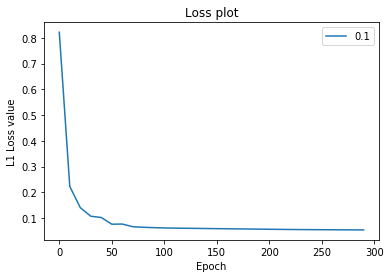

In [341]:
model_numpy,epoch,losslog,val_loss=train_neural_network(one_layer_model(20),epochs=300,learning_rate=0.1)

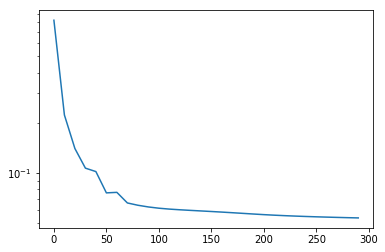

In [342]:
plt.plot(epoch,losslog)
plt.yscale('log')

## REMEMBER TO CHANGE FILENAME

In [343]:
np.savez("6element_neural_model.npz",
            w_array_0=model_numpy[0],
            b_array_0=model_numpy[1],
            w_array_1=model_numpy[2],
            b_array_1=model_numpy[3],
            input_mean=par_mean,
            input_std=par_std,
            output_mean=ab_mean,
            output_std=ab_std)

Now reconstruct neural network:

In [344]:
net_par=np.load("6element_neural_model.npz")
w0=np.asmatrix(net_par['w_array_0'])
w1=np.asmatrix(net_par['w_array_1'])
b0=np.asmatrix(net_par['b_array_0']).T
b1=np.asmatrix(net_par['b_array_1']).T
in_mean=net_par['input_mean']
in_std=net_par['input_std']
out_mean=net_par['output_mean']
out_std=net_par['output_std']

In [345]:
def relu(x):
    return np.maximum(0,x)
def tanh(x):
    return np.tanh(x)
def sigmoid(x):
    return 1./(1.+np.exp(-x))

In [346]:
def net_standard_output(standard_in_par,func):
    """Return neural network output (in standardized form)"""
    l1=np.matmul(w0,np.asmatrix(standard_in_par).T)+b0
    standard_out=np.matmul(w1,func(l1))+b1
    return standard_out
def net_output(in_par,activator):
    """Return physics neural network output for destandardized parameters"""
    # Standardize input:
    standard_in=(in_par-in_mean)/in_std
    # Reconstruct network
    standard_out=net_standard_output(standard_in,activator)
    # Destandardize output
    out = np.asarray(standard_out.T)*out_std+out_mean
    return out

In [347]:
def error_diagnostic(activator):
    """Return median error per element on the validation set"""
    nn_out = np.asarray(net_output(cut_params2T,activator))
    true_out = cut_abuns2T
    diff = np.abs(nn_out-true_out)
    low,med,up=np.percentile(diff,[17,50,83],axis=0)
    return med,med-low,up-med,diff

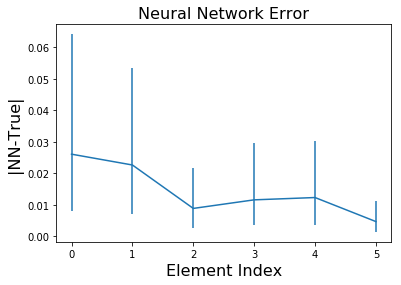

In [348]:
med,lo,hi,diff=error_diagnostic(relu)
plt.errorbar(range(len(els)),med,yerr=[lo,hi]);FS=16
plt.xlabel('Element Index',fontsize=FS);plt.ylabel('|NN-True|',fontsize=FS);plt.title('Neural Network Error',fontsize=FS);

In [349]:
print("Mean of Median Errors: %.3f+-%.3f"%(med.mean(),med.std()))
print("Mean of Overall Errors: %.3f+-%.3f"%(diff.ravel().mean(),diff.ravel().std()))

Mean of Median Errors: 0.014+-0.008
Mean of Overall Errors: 0.022+-0.032


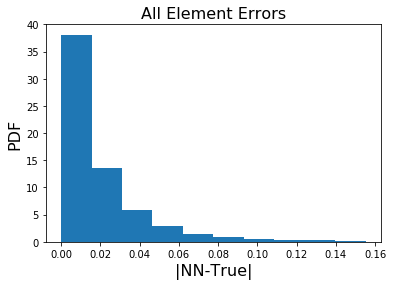

In [350]:
plt.hist(diff.ravel(),density=True,range=[0,np.percentile(diff.ravel(),99)]);
plt.ylabel('PDF',fontsize=FS);plt.xlabel('|NN-True|',fontsize=FS);plt.title('All Element Errors',fontsize=FS);

In [261]:
test_par=np.array([-2.4 , -2.85, -0.25 ,  0.65,  0.45, 7.3])
test_par_vector=np.asarray([test_par+0.01*u for u in range(4)])

Test this works:

In [176]:
net_output(test_par_vector)

array([[-0.3141325 ,  0.04138093,  0.08838361, -0.00907358, -0.3149259 ,
        -0.18520647,  0.02747781,  0.04380658,  0.12235451,  0.03404451,
         0.27527015,  0.0135476 , -0.00152054, -0.37285564, -0.36813658,
         0.21510533,  0.15422927, -0.14120768, -0.06337573,  0.2479228 ,
         0.07477703,  0.01203895,  0.12868471, -0.33215159,  0.16870801,
        -0.43455755, -0.15845536, -0.23636343],
       [-0.3121209 ,  0.04037782,  0.08613547, -0.01084036, -0.31462198,
        -0.1841944 ,  0.02792547,  0.04731142,  0.11839621,  0.03544525,
         0.27826572,  0.01665678, -0.00338434, -0.37536244, -0.36698086,
         0.21567517,  0.15038123, -0.13925417, -0.06264898,  0.24797596,
         0.07505594,  0.01342184,  0.12831928, -0.33056073,  0.16885149,
        -0.43453899, -0.15766626, -0.23393664],
       [-0.31011666,  0.03945479,  0.08399999, -0.01248341, -0.31428676,
        -0.18323192,  0.02835383,  0.05064502,  0.11458176,  0.03601989,
         0.28114015,  0.0196

Run Neural Network on the Test Set

In [177]:
indices=np.random.randint(0,len(trainX),10000)

In [178]:
nn_testY=np.asarray(net_standard_output(testX).T)
nn_trainY=np.asarray(net_standard_output(trainX[indices]).T)

In [179]:
nn_all_trainY=np.asarray(net_standard_output(trainX).T)

(array([1.1000e+01, 2.6300e+02, 1.8750e+03, 7.3070e+03, 1.4390e+04,
        1.5101e+04, 8.2040e+03, 2.3990e+03, 3.4100e+02, 2.8000e+01]),
 array([-4.1914706 , -3.36356977, -2.53566894, -1.70776811, -0.87986728,
        -0.05196645,  0.77593437,  1.6038352 ,  2.43173603,  3.25963686,
         4.08753769]),
 <a list of 10 Patch objects>)

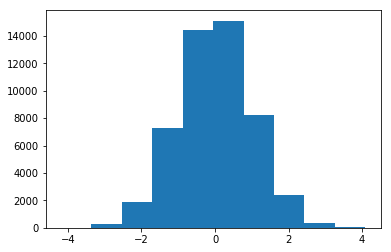

In [180]:
plt.hist(testX[:,2])

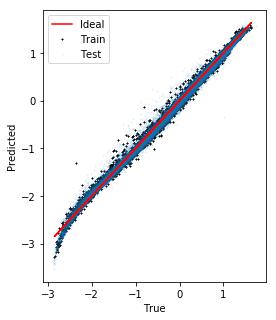

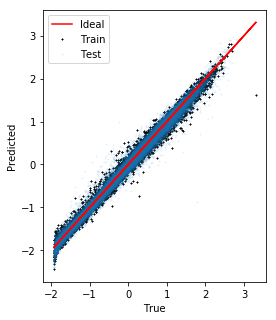

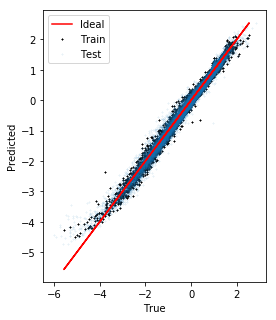

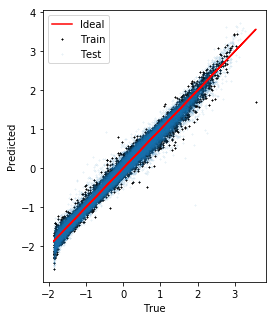

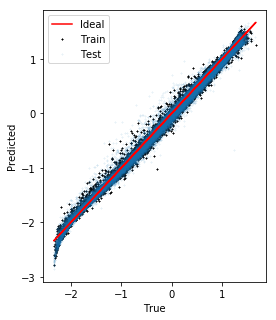

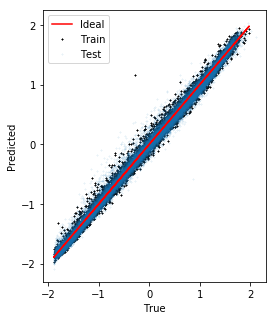

In [181]:
for index in range(6):
    plt.figure(figsize=(4,5))
    plt.scatter(trainY[indices,index],nn_trainY[:,index],c='k',marker='x',label='Train',s=1)
    plt.scatter(testY[:,index],nn_testY[:,index],alpha=0.1,marker='x',label='Test',s=1)
    plt.plot(trainY[indices,index],trainY[indices,index],c='r',label='Ideal');plt.legend();
    plt.ylabel('Predicted');plt.xlabel('True');

Look at data more carefully:

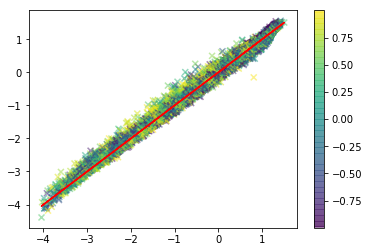

In [182]:
plt.scatter(testY[:,-1],nn_testY[:,-1],c=testX[:,5],marker='x',alpha=.5)
plt.plot(testY[:,-1],testY[:,-1],c='r');plt.colorbar();

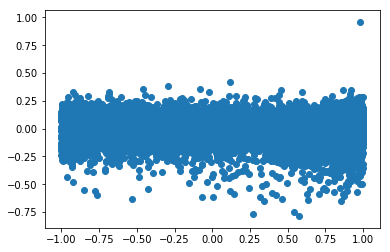

In [183]:
plt.scatter(testX[:,-1],testY[:,-1]-nn_testY[:,-1])

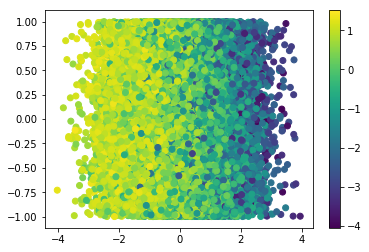

In [184]:
plt.scatter(testX[:,1],testX[:,5],c=testY[:,-1]);plt.colorbar()

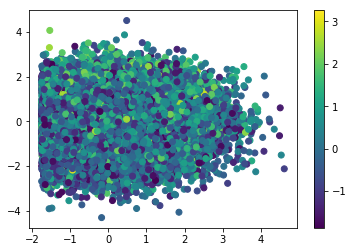

In [185]:
plt.scatter(testX[:,3],testX[:,4],c=testY[:,3]);plt.colorbar()